<a href="https://colab.research.google.com/github/sujithk1999/Advanced-Machine-Learning-Assessment/blob/main/Site_specific_weed_management_(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import inception_v3
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils import layer_utils
from tensorflow.keras.utils import to_categorical
from statistics import mean
import math
import cv2
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**Resizing the image and Loading the dataset**

In [28]:
# re-size all the images
IMAGE_SIZE = [224, 224]
#loading the data
train_dir = r"/content/drive/MyDrive/data_task1/train"
test_dir = r"/content/drive/MyDrive/data_task1/test"
val_dir = r"/content/drive/MyDrive/data_task1/val"

**Visualisation of dataset**

In [29]:
datasets = [r"/content/drive/MyDrive/data_task1/train"]

Classes = ["blackgrass","charlock","cleavers","fat hen","maize","wheat"]

n_classes = len(Classes)

Classes

['blackgrass', 'charlock', 'cleavers', 'fat hen', 'maize', 'wheat']

**Augmentation process**

In [30]:
def augmentation_classes(Classes,train_dir):
    size_dict={}
    for i,classes in enumerate(Classes):
         size_dict[Classes[i]]=len(os.listdir(os.path.join(train_dir, classes)))
    print('Sample sizes of different classes are\n\n',size_dict)
    values_list=list(size_dict.values())
    ideal_samples=math.ceil(mean(values_list)*1.1)
    required_aug=[]
    for i,j in enumerate(size_dict):
        if size_dict[j]<ideal_samples:
            required_aug.append(j)
    print('\n\nMinority classes requiring augmentations are\n',required_aug)
    return required_aug,ideal_samples,size_dict

In [31]:
def image_augmentation(raw_images):
    
    
    seq=iaa.Sequential([iaa.Fliplr(0.5),
                        iaa.Flipud(0.3),
                        iaa.LinearContrast((0.75, 1.5)),
                        iaa.Crop(percent=(0, 0.2)),
                        iaa.Affine(rotate=(-45, 45)),
                        iaa.GaussianBlur(sigma=(0.0, 3.0))
                        ])
    image_aug=seq(images=raw_images)
    return image_aug

In [32]:
def preprocessing(img_path):
    image = cv2.resize(cv2.imread(img_path), (224,224), interpolation = cv2.INTER_NEAREST)
    return image

In [33]:
def get_training_data( model):
        
    if model == "resnet50":
        datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
    elif model == "inceptionV3":
        datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
    elif model == 'vgg16':
        datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)

    train_data_den = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = "categorical",
            batch_size=32,
            shuffle=True,
            subset='training'
        )
        
    val_data_gen = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = 'categorical',
            batch_size=32,
            shuffle=False,
            subset='validation'
        )

    return train_data_den, val_data_gen

In [34]:
def augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict):
    for i,sample_class in enumerate(Classes):
        try:
            os.mkdir(os.path.join(save_dir,sample_class))
        except FileExistsError:
            pass
        img_list=[]
        for img_loc in os.listdir(os.path.join(train_dir,sample_class)):
            image = preprocessing(os.path.join(train_dir, sample_class, img_loc))
            img_list.append(image)
        if sample_class in required_aug:
            aug_img= image_augmentation(img_list)
            req_img=random.sample(aug_img,(ideal_samples-size_dict[sample_class]))
            img_list.extend(req_img)
        for image_number, image in enumerate(img_list):
            cv2.imwrite(os.path.join(save_dir, sample_class, "{}.png".format(image_number + 1)), image)

In [35]:
def model_prep(model_arch,monitor,lr_patience,early_stop_patience,min_lr):
    checkpoint = ModelCheckpoint(filepath=os.path.join(r'/content/drive/MyDrive/save file task 1',model_arch,'.h5'), monitor='val_acc', mode='max', save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=1, min_lr=min_lr)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=12, verbose=1, mode='min', restore_best_weights=True)
    #CSVLogger logs epoch, acc, loss, val_acc, val_loss
    log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
    callback=[checkpoint,early_stop, log_csv]
    train_gen, val_gen = get_training_data(model = model_arch)
    
    return callback,train_gen,val_gen

**Before Augmentation**

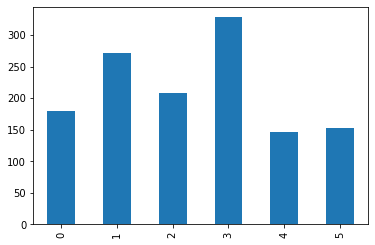

In [36]:
a={}
for i,classes in enumerate(Classes):
     a[i]=len(os.listdir(os.path.join(train_dir, classes)))
a=pd.DataFrame(a.items(),columns=['index','no.of samples'],index=a.keys())
a['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Finding the classes needing for the augmentation**

In [37]:
required_aug,ideal_samples,size_dict = augmentation_classes(Classes,train_dir)

Sample sizes of different classes are

 {'blackgrass': 180, 'charlock': 272, 'cleavers': 208, 'fat hen': 328, 'maize': 146, 'wheat': 153}


Minority classes requiring augmentations are
 ['blackgrass', 'cleavers', 'maize', 'wheat']


**Augmenting and storing data**

In [38]:
save_dir = r"/content/drive/MyDrive/save file task 1"

In [39]:
augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict)

**After augmentation**

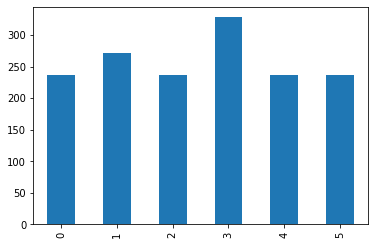

In [40]:
c={}
for i,classes in enumerate(Classes):
     c[i]=len(os.listdir(os.path.join(save_dir, classes)))
c=pd.DataFrame(c.items(),columns=['index','no.of samples'],index=c.keys())
c['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Model Training**

In [41]:
from tensorflow.keras.callbacks import CSVLogger

In [51]:
callback,train_gen,val_gen=model_prep('vgg16','val_loss',2,5,0.000001)

Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [53]:
# useful for getting number of classes
folders = glob(r"/content/drive/MyDrive/data_task1/train/*")

In [54]:
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(224, 224, 3))
x = vgg_model.output
x = Dropout(0.6)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = swish(x)
pred = Dense(12, activation='softmax')(x)
final_vgg_model = Model(inputs = vgg_model.input, outputs = pred)

for layer in vgg_model.layers[0:-4]:
    layer.trainable = False
    
final_vgg_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
history = final_model.fit_generator(
  train_gen,
  validation_data=val_gen,
  epochs=50,
  steps_per_epoch=len(train_gen),
  validation_steps=len(val_gen),
callbacks= callback)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
42/42 [==============================] - 26s 261ms/step - loss: 0.6335 - accuracy: 0.8000 - val_loss: 1.9191 - val_accuracy: 0.7074
Epoch 2/50
42/42 [==============================] - 9s 220ms/step - loss: 0.1370 - accuracy: 0.9430 - val_loss: 0.8234 - val_accuracy: 0.8646
Epoch 3/50
42/42 [==============================] - 9s 219ms/step - loss: 0.0302 - accuracy: 0.9863 - val_loss: 0.5752 - val_accuracy: 0.8952
Epoch 4/50
42/42 [==============================] - 9s 219ms/step - loss: 0.0112 - accuracy: 0.9977 - val_loss: 0.2947 - val_accuracy: 0.9476
Epoch 5/50
42/42 [==============================] - 9s 216ms/step - loss: 0.0779 - accuracy: 0.9871 - val_loss: 0.6343 - val_accuracy: 0.9083
Epoch 6/50
42/42 [==============================] - 9s 215ms/step - loss: 0.1208 - accuracy: 0.9665 - val_loss: 0.6270 - val_accuracy: 0.9214
Epoch 7/50
42/42 [==============================] - 9s 215ms/step - loss: 0.0690 - accuracy: 0.9757 - val_loss: 0.7557 - val_accuracy: 0.8734
Epoch

In [57]:
final_model.save('/content/drive/MyDrive/save file task 1/ResNet50_saved_models.hdf5')

Values stored in history are ... 
 {'loss': [0.6335408091545105, 0.13699117302894592, 0.030241763219237328, 0.011203412897884846, 0.077886663377285, 0.12084575742483139, 0.0689554437994957, 0.059507817029953, 0.01753346249461174, 0.008701168932020664, 0.0010479548946022987, 0.0011315110605210066, 0.0004006112867500633, 0.00038364841020666063, 0.04737356677651405, 0.04146936908364296, 0.03220514953136444, 0.014862075448036194, 0.012908490374684334, 0.00541461817920208, 0.1314699649810791, 0.03129374980926514, 0.010198610834777355, 0.0050031146965920925, 0.0013084905222058296, 0.0005543797742575407], 'accuracy': [0.800000011920929, 0.9429658055305481, 0.9863117933273315, 0.9977186322212219, 0.987072229385376, 0.9665399193763733, 0.9756653904914856, 0.9787072539329529, 0.9939163327217102, 0.9969581961631775, 1.0, 1.0, 1.0, 1.0, 0.989353597164154, 0.9847908616065979, 0.9885931611061096, 0.9961977005004883, 0.9961977005004883, 0.9977186322212219, 0.9726235866546631, 0.9916349649429321, 0.99

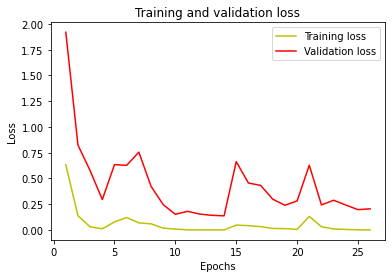

In [58]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Values stored in history are ... 
 {'loss': [0.6335408091545105, 0.13699117302894592, 0.030241763219237328, 0.011203412897884846, 0.077886663377285, 0.12084575742483139, 0.0689554437994957, 0.059507817029953, 0.01753346249461174, 0.008701168932020664, 0.0010479548946022987, 0.0011315110605210066, 0.0004006112867500633, 0.00038364841020666063, 0.04737356677651405, 0.04146936908364296, 0.03220514953136444, 0.014862075448036194, 0.012908490374684334, 0.00541461817920208, 0.1314699649810791, 0.03129374980926514, 0.010198610834777355, 0.0050031146965920925, 0.0013084905222058296, 0.0005543797742575407], 'accuracy': [0.800000011920929, 0.9429658055305481, 0.9863117933273315, 0.9977186322212219, 0.987072229385376, 0.9665399193763733, 0.9756653904914856, 0.9787072539329529, 0.9939163327217102, 0.9969581961631775, 1.0, 1.0, 1.0, 1.0, 0.989353597164154, 0.9847908616065979, 0.9885931611061096, 0.9961977005004883, 0.9961977005004883, 0.9977186322212219, 0.9726235866546631, 0.9916349649429321, 0.99

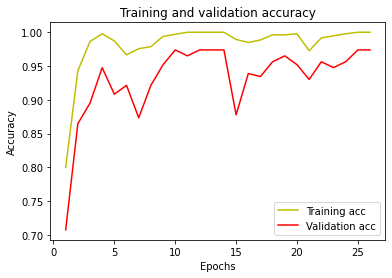

In [59]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Confusion matrix and prediction**

In [60]:
callback,train_gen,val_gen=model_prep('vgg16','val_loss',2,5,0.000001)
vgg_model = keras.models.load_model('/content/drive/MyDrive/ResNet50_saved_models.hdf5')
vgg_model.evaluate_generator(generator=val_gen)



Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.13680483400821686, 0.9737991094589233]

In [61]:
predictions = vgg_model.predict_generator(val_gen,28)
y_pred = np.argmax(predictions, axis=1)
cf_matrix = confusion_matrix(val_gen.classes, y_pred)
print('Classification Report')
print(classification_report(val_gen.classes, y_pred, target_names=Classes))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Classification Report
              precision    recall  f1-score   support

  blackgrass       0.97      0.97      0.97        35
    charlock       1.00      0.97      0.99        40
    cleavers       1.00      1.00      1.00        35
     fat hen       0.98      0.98      0.98        49
       maize       1.00      0.91      0.96        35
       wheat       0.90      1.00      0.95        35

    accuracy                           0.97       229
   macro avg       0.97      0.97      0.97       229
weighted avg       0.98      0.97      0.97       229



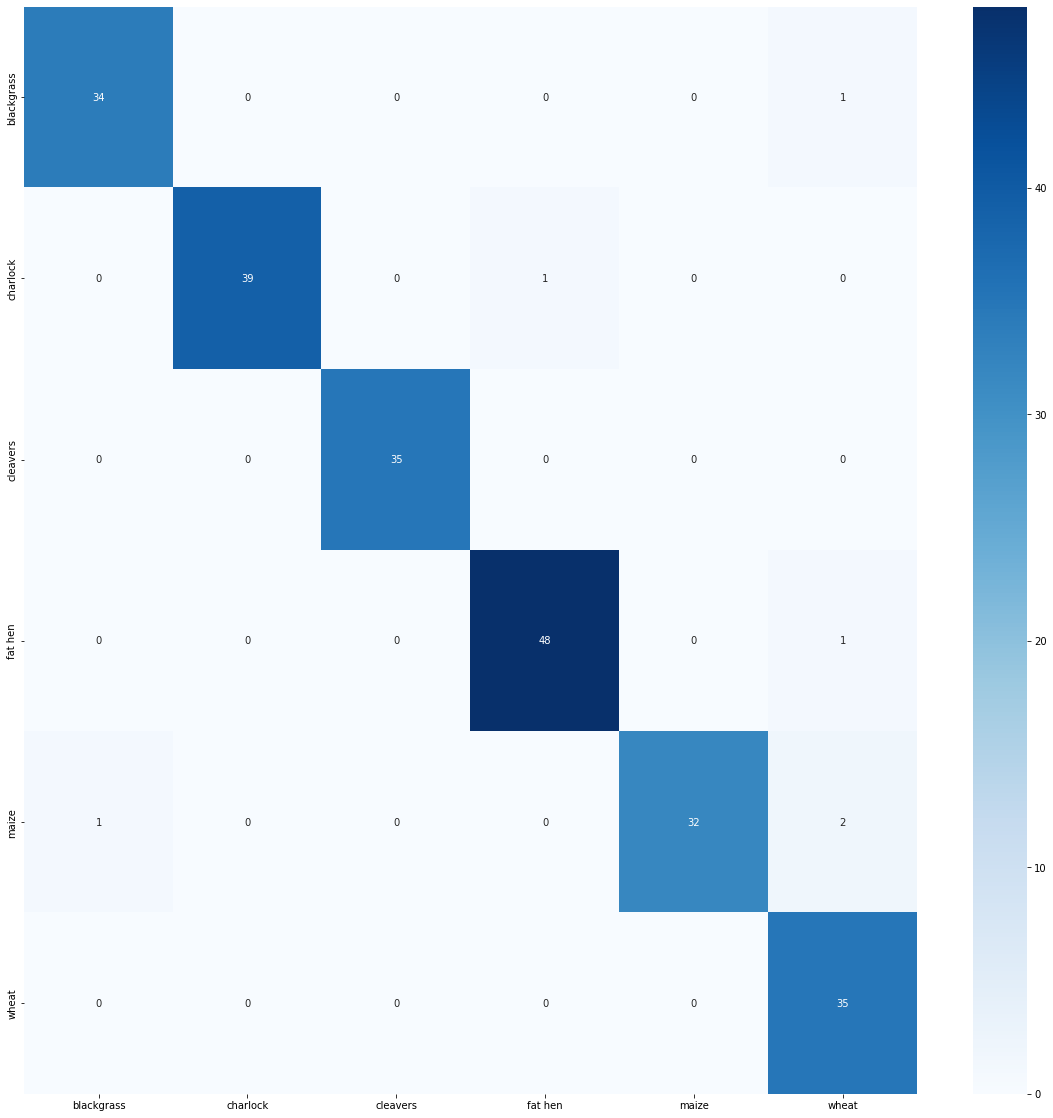

In [62]:
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, xticklabels=Classes, yticklabels=Classes, cmap='Blues')